$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\Xvh}{\hat{\mathbf{X}}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\Yv}{\mathbf{Y}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\gv}{\mathbf{g}}
\newcommand{\Hv}{\mathbf{H}}
\newcommand{\dv}{\mathbf{d}}
\newcommand{\Vv}{\mathbf{V}}
\newcommand{\vv}{\mathbf{v}}
\newcommand{\Uv}{\mathbf{U}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\Zv}{\mathbf{Z}}
\newcommand{\Zvh}{\hat{\mathbf{Z}}}
\newcommand{\Ev}{\mathbf{E}}
\newcommand{\onev}{\mathbf{1}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}
\newcommand{\dimensionbar}[1]{\underset{#1}{\operatorname{|}}}
$


# A2.4 Three-Layer Neural Network

Brent Staab

For this assignment, we modify the two-layer neural network matrix equations and code from lecture notes to become a three-layer neural network, one with two hidden layers.  In the following diagram, you will be adding another layer on the left between in the inputs, $x$, and the show hiddden layer.

You must complete three steps.
1. Complete the matrix equations using latex notation in the markdown cell,
2. Implement the required functions in python.
3. Perform the described experiments.

## Network Diagram
Three-layer neural network with two hidden layers

![Two Layers](http://www.cs.colostate.edu/~anderson/cs545/notebooks/net-A2.png)

$$ 
\begin{align*}
N &= \text{ number of samples } \\
I &= \text{ the number of attributes in each sample }\\
K &= \text{ number of units in output layer } \\
H_1 &= \text{ number of units in first hidden layer }\\
H_2 &= \text{ number of units in second hidden layer }\\
~\\
\Zv_1 &= \tanh(\Xvh\, \Uv) \\
\Zv_2 &= \tanh(\Zvh_1\, \Vv) \\
\Yv &= \Zvh_2\, \Wv\\
\Ev &= \frac{1}{NK} \sum_{n=1}^N \sum_{k=1}^K (\Tv_{n,k} - \Yv_{n,k})^2 \\
~\\
%------------------------------------
% Gradient of 'E' with respect to 'Y'
\nabla_\Yv E_{n,k} &= \frac{-2}{NK} (\Tv_{n,k} - \Yv_{n,k})\\
~\\ 
%------------------------------------
% Gradient of 'E' with respect to 'W'
\nabla_\Wv E &=  \Zvh_2^T \delta_\Yv \;\;\;\;\text{ where } \delta_\Yv = \frac{-2}{NK} (\Tv - \Yv)\\
~\\ 
%------------------------------------
% Gradient of 'E' with respect to 'V'
\nabla_\Vv E &= \Zvh_1^T \; \delta_{\Zv_2} \;\;\;\;\text{ where } \delta_{\Zv_2} = (\delta_\Yv \; \Wv_{1:}^T)\; \cdot\; (1-\Zv_2^2) \;\;\;\; \text{ if } f(\Zvh_1 \Vv) = \tanh(\Zvh_1 \Vv)\\
~\\ 
%------------------------------------
% Gradient of 'E' with respect to 'U'
\nabla_\Uv E &= \Xvh^T \; \delta_{\Zv_1} \;\;\;\;\text{ where } \delta_{\Zv_z1} = (\delta_{\Zv_2} \; \Vv_{1:}^T)\; \cdot\; (1-\Zv_1^2) \;\;\;\; \text{ if } f(\Xvh \Uv) = \tanh(\Xvh \Uv)\\
\end{align*}
$$

## Code

Modify the functions `network` `error_gradient` and `mse` to do the compuations for a three-layer neural network.  They must have the following arguments:
* `Y = network(w, n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, all_outputs=False)`
or
* `Y, Z1, Z2 = network(w, n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, all_outputs=True)`
* `gradient = error_gradient(w, n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, T)`
* `mean_squared_error = mse(w, n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, T)`

### Import code needed in this notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import pandas
import optimizers as opt  # from Lecture Notes

### network function

In [2]:
# -------------------------------------------------------
# Defines the forward calculation of a three layer neural 
# network with two hidden layers
# Inputs:
#    w           : Weights for ALL layers   
#    n_inputs    : Number of input values
#    n_hiddens_1 : Number of elements in hidden layer 1
#    n_hiddens_2 : Number of elements in hidden layer 2
#    n_outputs   : Number of outputs
#    X           : Input data
#    all_outputs : Flag that controls output content
#                  TRUE  = Y, Z1 & Z2
#                  FALSE = Y
# Output:
#   Data from the network based on 'all_outputs' flag
def network(w, n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, all_outputs=False):
    # Determine amount of data (number of weights) for each layer
    n_U = (n_inputs + 1) * n_hiddens_1
    n_V = (n_hiddens_1 + 1) * n_hiddens_2
    
    # 'w' contains data for ALL layers.  Extract the data for each
    # layer based on size determined above
    U = w[0:n_U].reshape((n_inputs + 1, n_hiddens_1))
    V = w[n_U: n_U + n_V].reshape((n_hiddens_1 + 1, n_hiddens_2))
    W = w[n_U + n_V:].reshape((n_hiddens_2 + 1, n_outputs))
    
    # Determine the output of each Layer (forward calculation)
    Z_1 = np.tanh(U[0:1, :] + X @ U[1:, :])
    Z_2 = np.tanh(V[0:1, :] + Z_1 @ V[1:, :])
    Y = W[0:1, :] + Z_2 @ W[1:, :]
    
    # Return output and conditionally the values from the hidden layers
    return (Y, Z_1, Z_2) if all_outputs else Y 

##### network function verification 
This is from A2grader.py

In [3]:
X = np.arange(3 * 4).reshape((3, 4)) * 0.1
T = np.hstack(( np.sin(X[:, 0:1]) + X[:, 1:2],
                X[:, 2:3] * -0.5,
                X[:, 3:4] ** 2))
n_inputs = X.shape[1]
n_outputs = T.shape[1]
n_hiddens_1 = 6
n_hiddens_2 = 2
n_w = (n_inputs + 1) * n_hiddens_1 + (n_hiddens_1 + 1) * n_hiddens_2 + (n_hiddens_2 + 1) * n_outputs
w = (np.arange(n_w) - n_w/2) * 0.01

In [4]:
Y = network(w, n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X)
Y

array([[0.12022254, 0.12773632, 0.13525011],
       [0.08581156, 0.09176614, 0.09772072],
       [0.05582873, 0.06042448, 0.06502022]])

In [5]:
Y, Z1, Z2 = network(w, n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, all_outputs=True)
print('-' * 80)
print("Y =")
print(Y)
print('-' * 80)
print("Z1 =")
print(Z1)
print('-' * 80)
print("Z2 =")
print(Z2)

--------------------------------------------------------------------------------
Y =
[[0.12022254 0.12773632 0.13525011]
 [0.08581156 0.09176614 0.09772072]
 [0.05582873 0.06042448 0.06502022]]
--------------------------------------------------------------------------------
Z1 =
[[-0.29496888 -0.28029298 -0.26548486 -0.25055041 -0.23549575 -0.22032722]
 [-0.45262762 -0.4268185  -0.40029486 -0.37308313 -0.34521403 -0.31672254]
 [-0.58629394 -0.55390692 -0.51975207 -0.4838508  -0.44624361 -0.40699138]]
--------------------------------------------------------------------------------
Z2 =
[[-0.12161728 -0.12700392]
 [-0.19596638 -0.20857586]
 [-0.26095696 -0.27946846]]


### error_gradient function

In [6]:
# -------------------------------------------------------
# Defines the error_gradient calculation of a three layer
# neural network with two hidden layers
# Inputs:
#    w           : Weights for ALL layers   
#    n_inputs    : Number of input values
#    n_hiddens_1 : Number of elements in hidden layer 1
#    n_hiddens_2 : Number of elements in hidden layer 2
#    n_outputs   : Number of outputs
#    X           : Input data
#    T           : Target values (i.e. expected outputs)
# Output:
#   The adjustment needed for each weight in all layers and units
def error_gradient(w, n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, T):
    Y, Z1, Z2 = network(w, n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, all_outputs=True)
    n_samples = X.shape[0]
    delta_Y = -2 / (n_samples * n_outputs) * (T - Y)
    Z2_hat = np.insert(Z2, 0, 1, axis=1)
    dEdW = Z2_hat.T @ delta_Y
    
    # Determine amount of data for each layer
    n_U = (n_inputs + 1) * n_hiddens_1
    n_V = (n_hiddens_1 + 1) * n_hiddens_2
    n_W = (n_hiddens_2 + 1) * n_outputs
    
    # 'w' contains data for each layer, extract the data
    # based on size determined above
    # I think this is good
    U = w[0:n_U].reshape((n_inputs + 1, n_hiddens_1))
    V = w[n_U: n_U + n_V].reshape((n_hiddens_1 + 1, n_hiddens_2))
    W = w[n_U + n_V:].reshape((n_hiddens_2 + 1, n_outputs))
    
    # Gradient of E with respect to V
    delta_Z2 = (delta_Y @ W[1:, :].T) * (1 - Z2**2)
    Z1_hat = np.insert(Z1, 0, 1, axis=1)
    dEdV = Z1_hat.T @ delta_Z2
    
    # Gradient of E with respect to U
    delta_Z1 = (delta_Z2 @ V[1:, :].T) * (1 - Z1**2)
    X_hat = np.insert(X, 0, 1, axis=1)
    dEdU = X_hat.T @ delta_Z1
 
    dEdw = np.hstack((dEdU.flatten(), dEdV.flatten(), dEdW.flatten()))

    return dEdw

##### error_gradient function Verification 
This is from A2grader.py

In [7]:
grad = error_gradient(w, n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, T)
grad

array([-0.01004135, -0.0140896 , -0.01848553, -0.0232127 , -0.02824685,
       -0.0335556 , -0.00785947, -0.01100037, -0.01440092, -0.01804931,
       -0.02192779, -0.02601239, -0.00886361, -0.01240933, -0.01624947,
       -0.02037058, -0.02475247, -0.02936795, -0.00986774, -0.01381829,
       -0.01809803, -0.02269185, -0.02757716, -0.03272351, -0.01087188,
       -0.01522725, -0.01994658, -0.02501312, -0.03040184, -0.03607907,
       -0.11689819, -0.13210337,  0.0677528 ,  0.07656248,  0.06395863,
        0.0722746 ,  0.05997313,  0.0677706 ,  0.0557992 ,  0.06305375,
        0.05144169,  0.05812953,  0.04690754,  0.0530058 , -0.52109147,
        0.26220599, -0.33155754,  0.12500265, -0.05571474,  0.08225796,
        0.13365384, -0.05939052,  0.08801306])

### mse (mean-squared-error) function

In [8]:
# -------------------------------------------------------
# Defines the mean squared erro calculation for a three 
# layer neural network with two hidden layers
# Inputs:
#    w           : Weights for ALL layers   
#    n_inputs    : Number of input values
#    n_hiddens_1 : Number of elements in hidden layer 1
#    n_hiddens_2 : Number of elements in hidden layer 2
#    n_outputs   : Number of outputs
#    X           : Input data
#    T           : Target values (i.e. expected outputs)
# Output:
#   The mean squared error result
def mse(w, n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, T):
    Y =  network(w, n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X)
    return np.mean((T - Y)**2)

## Test on Air Quality Data
Use your code to, as before, predict CO from the Hour of the day.

Set up the data matrices `X` and `T` as follows.

In [9]:
data = pandas.read_csv('AirQualityUCI.csv', delimiter=';', decimal=',', usecols=range(15), na_values=-200)
data = data[['Time', 'CO(GT)']]
data = data [:23 * 20]  # first 20 days of data
data = data.dropna(axis=0)
print('data.shape =', data.shape)

hour = [int(t[:2]) for t in data['Time']]
X = np.array(hour).reshape(-1, 1)
CO = data['CO(GT)']
T = np.array(CO).reshape(-1, 1)
np.hstack((X, T))[:10]  # show the first 10 samples of hour, CO

data.shape = (443, 2)


array([[18. ,  2.6],
       [19. ,  2. ],
       [20. ,  2.2],
       [21. ,  2.2],
       [22. ,  1.6],
       [23. ,  1.2],
       [ 0. ,  1.2],
       [ 1. ,  1. ],
       [ 2. ,  0.9],
       [ 3. ,  0.6]])

Define the network parameters.  Use the shapes of `X` and `T` to assign the number of inputs and outputs.  Define each of the two hidden layers to have 5 units.

In [10]:
n_inputs = X.shape[1]
n_hiddens_1 = 5
n_hiddens_2 = 5
n_outputs = T.shape[1]
print("n_inputs({}) n_hiddens_1({}) n_hiddens_2({}) n_outputs({})".format(
    n_inputs, n_hiddens_1, n_hiddens_2, n_outputs))

n_inputs(1) n_hiddens_1(5) n_hiddens_2(5) n_outputs(1)


Now we must define the intial weight vector.  The vector contains a value for each weight in all three layers.

In [11]:
n_U = (n_inputs + 1) * n_hiddens_1
n_V = (n_hiddens_1 + 1) * n_hiddens_2
n_W = (n_hiddens_2 + 1) * n_outputs

initial_w = np.random.uniform(-0.1, 0.1, n_U + n_V + n_W)  # range of weights is -0.1 to 0.1
print("n_U({}) n_V({}) n_W({})".format(n_U, n_V, n_W))

n_U(10) n_V(30) n_W(6)


Before training our network, standardize the input values, to change the hour to have zero mean and unit variance across the set of samples.  Change `True` to `False` to not perform this step, allowing you to compare results with and without standardization.  It is not required to show the results here.  When you check in your notebook, leave `standardize` set to `True`.

In [12]:
standardize = True

if standardize:
    X_mean = X.mean(axis=0)
    X_std = X.std(axis=0)
    X = (X - X_mean) / X_std
    
print(f'X mean is {X.mean(axis=0)[0]:.3f} and its standard deviation is {X.std(axis=0)[0]:.3f}')

X mean is 0.000 and its standard deviation is 1.000


Now we can train our network using each of our three optimization algorithms.

In [13]:
n_iterations = 2000

result_sgd = opt.sgd(initial_w,
                     mse, error_gradient, fargs=[n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, T],
                     n_iterations=n_iterations, learning_rate=1e-1, momentum_rate=0.2, 
                     save_wtrace=True)
print(f'SGD final error is {result_sgd["ftrace"][-1]:.3f} and it took {result_sgd["time"]:.2f} seconds')

result_adam = opt.adam(initial_w, 
                       mse, error_gradient, fargs=[n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, T],
                       n_iterations=n_iterations, learning_rate=1e-2, 
                       save_wtrace=True)
print(f'Adam final error is {result_adam["ftrace"][-1]:.3f} and it took {result_adam["time"]:.2f} seconds')

result_scg = opt.scg(initial_w,
                     mse, error_gradient, fargs=[n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, T],
                     n_iterations=n_iterations,
                     save_wtrace=True)
print(f'SCG final error is {result_scg["ftrace"][-1]:.3f} and it took {result_scg["time"]:.2f} seconds')

SGD final error is 1.167 and it took 0.99 seconds
Adam final error is 1.200 and it took 1.07 seconds
SCG final error is 0.912 and it took 2.11 seconds


Examine the error curve and the model fits for each of the optimization algorithms.

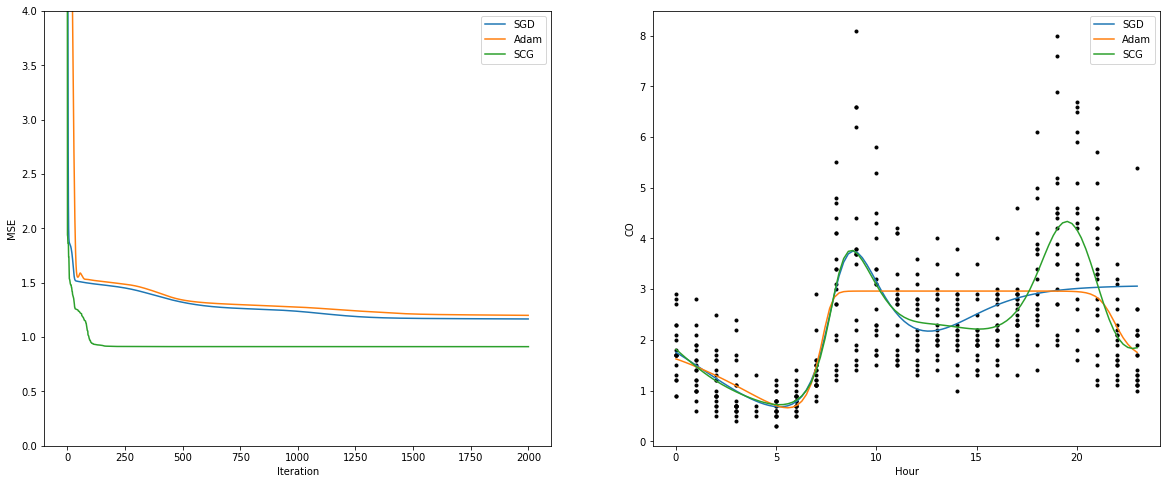

In [14]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(result_sgd['ftrace'], label='SGD')
plt.plot(result_adam['ftrace'], label='Adam')
plt.plot(result_scg['ftrace'], label='SCG')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.ylim(0, 4)

plt.subplot(1, 2, 2)
if standardize:
    plt.plot(X * X_std + X_mean, T, 'k.')  # unstandardize X
else:
    plt.plot(X, T, 'k.')
xs = np.linspace(0, 23, 100).reshape((-1, 1))
xs_standardized = (xs - X_mean) / X_std if standardize else xs
plt.plot(xs, network(result_sgd['w'], n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, xs_standardized), label='SGD')
plt.plot(xs, network(result_adam['w'], n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, xs_standardized), label='Adam')
plt.plot(xs, network(result_scg['w'], n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, xs_standardized), label='SCG')
plt.legend()
plt.xlabel('Hour')
plt.ylabel('CO');

The plot on the left shows the mean squared error (MSE) for a network trained with the three algorithms vs the number of training iterations.  The 'SCG' algorithm achieves the best result (lowest MSE) the quickest and shows no change after about 200 iterations.  The 'sgd' and 'adam' functions show very similar behavior and flatten off around 1500 iterations.  The plot on the right shows how the training data (black dots) and predicted output from the network for the three algorithms.  Also, you should be able to tell that the  final mse values reported from the training data (code cell 13) are consisten with the plotted data.  The 'adam' function looks the least like the training data and the 'scg' function produced the best result

Here is some code that tries a number of values for the key parameters of `n_iterations`, `n_hiddens_1`, `n_hiddens_2` and `learning_rate`.

**Required:** Modify the lists of values in the four for loops to try other parameter values.  Try to find ranges that work well for all three algorithms.

In [15]:
results = []
for n_iterations in [1, 10, 100, 500, 1000]:
    for nh1 in [1, 2, 5, 20]:
        for nh2 in [1, 2, 5, 20]:
            
            n_U = (n_inputs + 1) * nh1
            n_V = (nh1 + 1) * nh2
            n_W = (nh2 + 1) * n_outputs
            initial_w = np.random.uniform(-0.1, 0.1, n_U + n_V + n_W)

            result_scg = opt.scg(initial_w, mse, error_gradient, fargs=[n_inputs, nh1, nh2, n_outputs, X, T],
                                 n_iterations=n_iterations)
            results.append([n_iterations, nh1, nh2, 0, 'scg', result_scg['ftrace'][-1]])
            
            for lr in [1e-3, 1e-5, 0.1, 0.2, 0.5]:
                result_sgd = opt.sgd(initial_w, mse, error_gradient, fargs=[n_inputs, nh1, nh2, n_outputs, X, T],
                                     n_iterations=n_iterations, learning_rate=lr, momentum_rate=0)
                result_adam = opt.adam(initial_w, mse, error_gradient, fargs=[n_inputs, nh1, nh2, n_outputs, X, T],
                                       n_iterations=n_iterations, learning_rate=lr)

                results.append([n_iterations, nh1, nh2, 'scg', result_scg['ftrace'][-1]])
                results.append([n_iterations, nh1, nh2, lr, 'sgd', result_sgd['ftrace'][-1]])
                results.append([n_iterations, nh1, nh2, lr, 'adam', result_adam['ftrace'][-1]])

results = pandas.DataFrame(results, columns=('Iterations', 'nh1', 'nh2', 'lr', 'algo', 'mse'))
results

,Iterations,nh1,nh2,lr,algo,mse
0,1,1,1,0,scg,1.884524
1,1,1,1,scg,1.88452,NaN
2,1,1,1,0.001,sgd,6.902777
3,1,1,1,0.001,adam,6.902777
4,1,1,1,scg,1.88452,NaN
...,...,...,...,...,...,...
1275,1000,20,20,0.2,sgd,1.207252
1276,1000,20,20,0.2,adam,1.222114
1277,1000,20,20,scg,0.91002,NaN
1278,1000,20,20,0.5,sgd,1.547093


### Analyzing the results

##### 'scg' 
Filter the 'scg' results and only display the top ten results (lowest 'mse')

In [16]:
results[results.algo == 'scg'].sort_values(by=['mse'], ascending=True).head(10)

,Iterations,nh1,nh2,lr,algo,mse
1264,1000,20,20,0,scg,0.910020
1248,1000,20,5,0,scg,0.912209
1184,1000,5,5,0,scg,0.912220
1008,500,20,20,0,scg,0.912268
1200,1000,5,20,0,scg,0.912318
1168,1000,5,2,0,scg,0.912482
992,500,20,5,0,scg,0.912529
928,500,5,5,0,scg,0.912620
944,500,5,20,0,scg,0.913510
1056,1000,1,5,0,scg,0.915009


The best result found was with the largest number of iterations (1000), twenty units in hidden layer one and two and the smallest leearning rate. Also, it looks like you get very similar results with half the iterations, or the maximum number of iterations and more units in either hidden layer.

##### 'sgd' 
Filter the 'sgd' results and only display the top ten results (lowest 'mse')

In [17]:
results[results.algo == 'sgd'].sort_values(by=['mse'], ascending=True).head(10)

,Iterations,nh1,nh2,lr,algo,mse
1259,1000,20,5,0.2,sgd,1.146370
1195,1000,5,5,0.2,sgd,1.171821
1211,1000,5,20,0.2,sgd,1.190995
1118,1000,2,2,0.5,sgd,1.205199
1275,1000,20,20,0.2,sgd,1.207252
1150,1000,2,20,0.5,sgd,1.220543
1131,1000,2,5,0.2,sgd,1.235319
1272,1000,20,20,0.1,sgd,1.238063
955,500,5,20,0.2,sgd,1.241002
1019,500,20,20,0.2,sgd,1.241758


The best result was found with the largest number of iterations (1000), twenty units in hidden layer one, five units in hidden layer two and a learning rate of 0.2.  Overall, the number of iterations seems to have the biggest impact, followed by the learning rate and number of units in a hidden layer.

##### 'adam' 
Filter the 'adam' results and only display the top ten results (lowest 'mse')

In [18]:
results[results.algo == 'adam'].sort_values(by=['mse'], ascending=True).head(10)

,Iterations,nh1,nh2,lr,algo,mse
1212,1000,5,20,0.2,adam,0.910810
1273,1000,20,20,0.1,adam,0.911444
1151,1000,2,20,0.5,adam,0.911827
956,500,5,20,0.2,adam,0.911935
1196,1000,5,5,0.2,adam,0.912315
1017,500,20,20,0.1,adam,0.912371
1148,1000,2,20,0.2,adam,0.912516
1145,1000,2,20,0.1,adam,0.912519
1193,1000,5,5,0.1,adam,0.912652
1177,1000,5,2,0.1,adam,0.912891


The best result was found with 1000 iterations, the five units in hidden layer one, twenty units in hidden layer two and a learning rate of 0.2.  You can see from the best result and the fourth best result that doubling the number of iterations, with everything else being the same, results in less than 0.1% improvement.

### Overall result summary

These are the best results for each algorithm, taken from the filtered data above.  
- 1264 	  1000 	20 	20 	0 	    scg 	0.910020
- 1259 	  1000 	20 	5 	0.2 	sgd 	1.146370
- 1212 	  1000 	5 	20 	0.2 	adam 	0.910810
  
It can be seen that the best performance was achieved with some combination of five or twenty units hidden layer one and two.  The 'scg' and 'adam' algorithms were statistically identical with a learning rate of 1e-5 and 0.2 respectively.  
  
While experimenting with the four for loop values, I encountered the following warnings.  
- RuntimeWarning: overflow encountered in reduce  
- RuntimeWarning: overflow encountered in square  
- RuntimeWarning: overflow encountered in matmul  
- RuntimeWarning: invalid value encountered in multiply  

Via print statements, I found that this was only an issue at the higher learning rates and it didn't affect all results.  Since they were only warnings, I kept the range used for experimentation in the final notebook.  That being said, if I had to select new ranges for each for loop, I'd use  
- for n_iterations in [1000]:  
- for nh1 in [5, 20]:  
- for nh2 in [20, 5]:  
- for lr in [1e-5, 0.2]:

**Required:** Show the results for the 20 lowest MSE values, sorted by increasing MSE. Read about the `sort_values` and `head` methods on a `DataFrame`.  You can do this with a single line of python code.

In [19]:
# NOTE: 'ascending=True' is the default, but setting it to be explicit
results.sort_values(by=['mse'], ascending=True).head(20)

,Iterations,nh1,nh2,lr,algo,mse
1264,1000,20,20,0,scg,0.910020
1212,1000,5,20,0.2,adam,0.910810
1273,1000,20,20,0.1,adam,0.911444
1151,1000,2,20,0.5,adam,0.911827
956,500,5,20,0.2,adam,0.911935
1248,1000,20,5,0,scg,0.912209
1184,1000,5,5,0,scg,0.912220
1008,500,20,20,0,scg,0.912268
1196,1000,5,5,0.2,adam,0.912315
1200,1000,5,20,0,scg,0.912318


Since you have cleverly written your code to handle any value of $I$, $H_1$, $H_2$, and $K$, your code should be able to handle the following data that contains three attributes for each of 5 samples and two output values for each sample.

In [20]:
X = np.arange(15).reshape((5, 3))
T = np.hstack((X[:, 0:1] * 0.1 * X[:, 1:2], X[:, 2:]**2)) # making two target values for each sample
T = T.reshape((5, 2))
print('  Input            Target')
for x, t in zip(X, T):
    print(x, '\t', t)

  Input            Target
[0 1 2] 	 [0. 4.]
[3 4 5] 	 [ 1.2 25. ]
[6 7 8] 	 [ 4.2 64. ]
[ 9 10 11] 	 [  9. 121.]
[12 13 14] 	 [ 15.6 196. ]


Let's use your code to train a neural network with two hidden layers, having 50 units in the first hidden layer and 3 units in the second hidden layer.  This example does not perform the standardization step.

In [21]:
n_hiddens_1 = 50
n_hiddens_2 = 3
n_iterations = 1000


n_inputs = X.shape[1]
n_outputs = T.shape[1]

n_U = (n_inputs + 1) * n_hiddens_1
n_V = (n_hiddens_1 + 1) * n_hiddens_2
n_W = (n_hiddens_2 + 1) * n_outputs

initial_w = np.random.uniform(-0.1, 0.1, n_U + n_V + n_W)  # range of weights is -0.1 to 0.1

result_sgd = opt.sgd(initial_w,
                     mse, error_gradient, fargs=[n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, T],
                     n_iterations=n_iterations, learning_rate=1e-1, momentum_rate=0.2, 
                     save_wtrace=True)
print(f'SGD final error is {result_sgd["ftrace"][-1]:.3f} and it took {result_sgd["time"]:.2f} seconds')

result_adam = opt.adam(initial_w, 
                       mse, error_gradient, fargs=[n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, T],
                       n_iterations=n_iterations, learning_rate=1e-2, 
                       save_wtrace=True)
print(f'Adam final error is {result_adam["ftrace"][-1]:.3f} and it took {result_adam["time"]:.2f} seconds')

result_scg = opt.scg(initial_w,
                     mse, error_gradient, fargs=[n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, T],
                     n_iterations=n_iterations,
                     save_wtrace=True)
print(f'SCG final error is {result_scg["ftrace"][-1]:.3f} and it took {result_scg["time"]:.2f} seconds')

SGD final error is 2433.744 and it took 0.23 seconds
Adam final error is 3359.516 and it took 0.26 seconds
SCG final error is 0.038 and it took 0.43 seconds


In [22]:
w = result_scg['w']

Y = network(w, n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X)
Y.shape

(5, 2)

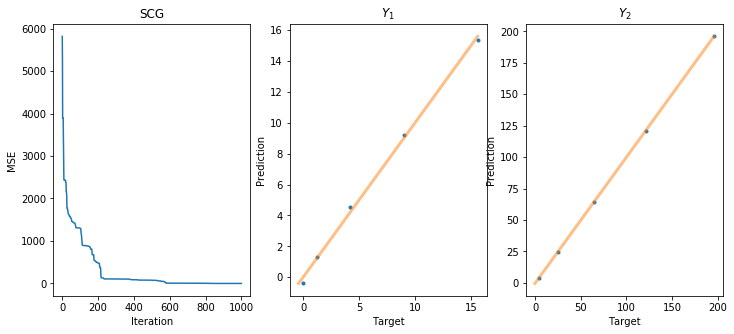

In [23]:
def plot_diagonal(T, Y):
    a = min(T.min(), Y.min())
    b = max(T.max(), Y.max())
    plt.plot([a, b], [a, b], '-', lw=3, alpha=0.5)

plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.plot(result_scg['ftrace'])
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.title('SCG')

plt.subplot(1, 3, 2)
plt.plot(T[:, 0], Y[:, 0], '.')
plot_diagonal(T[:, 0], Y[:, 0])
plt.xlabel('Target')
plt.ylabel('Prediction')
plt.title('$Y_1$')

plt.subplot(1, 3, 3)
plt.plot(T[:, 1], Y[:, 1], '.')
plot_diagonal(T[:, 1], Y[: 1])
plt.xlabel('Target')
plt.ylabel('Prediction')
plt.title('$Y_2$');

The left most plot shows the mean squared error vs iteration for a network trained with the 'scg' algorithm and 50 units in hidden layer 1 and 3 units in hidden layer two and two outputs.  The error quickly reduces to a near zero value in ~200 iterations and reaches the final mse around 600 iterations.  The middle and right plot shows the the performance of the first and second output respectively.  Since all predicted values (blue dots) are essentially on the target line (orange line), it confirms the error rate reported.

## Grading

Your notebook will be run and graded automatically. Test this grading process by first downloading [A2grader.zip](http://www.cs.colostate.edu/~anderson/cs545/notebooks/A2grader.zip) and extract `A2grader.py` from it. Run the code in the following cell to demonstrate an example grading session. You should see a perfect execution score of 80/80 if your functions are defined correctly. The remaining 20 points will be based on other testing and the results you obtain and your discussions. 

A different, but similar, grading script will be used to grade your checked-in notebook. It will include additional tests. You should design and perform additional tests on all of your functions to be sure they run correctly before checking in your notebook.  

For the grading script to run correctly, you must first name this notebook as 'Lastname-A2.ipynb' with 'Lastname' being your last name, and then save this notebook.

In [24]:
%run -i A2grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Staab-A2.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing
X = np.arange(3 * 4).reshape((3, 4)) * 0.1
T = np.hstack(( np.sin(X[:, 0:1]) + X[:, 1:2],
                X[:, 2:3] * -0.5,
                X[:, 3:4] ** 2))
n_inputs = X.shape[1]
n_outputs = T.shape[1]
n_hiddens_1 = 6
n_hiddens_2 = 2
n_w = (n_inputs + 1) * n_hiddens_1 + (n_hiddens_1 + 1) * n_hiddens_2 + (n_hiddens_2 + 1) * n_outputs
w = (np.arange(n_w) - n_w/2) * 0.01
Y = network(w, n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X)


--- 20/20 points. Returned correct values.

Testing
Y, Z1, Z2 = network(w, n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, all_outputs=True)


--- 20/20 points. Returned correct values.

Testing
grad = error_gradient(w, n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, T)

grad [-0.01004135 -0.0140896  -0.018485

## Check-In

Do not include this section in your notebook.

Name your notebook ```Lastname-A2.ipynb```.  Submit the file using the ```Assignment 2``` link on [Canvas](https://colostate.instructure.com/courses/86986).

## Extra Credit

Train a neural network with two hidden layers with five units in each layer to predict CO from the Hour of the day.  After it is trained plot the outputs of the five units in the first hidden layer versus 100 floating point values of hour from 0 to 23 in one subplot of one figure.  Then, in another subplot plot the outputs of the five units in the second hidden layer.  In a third subplot, plot the predicted CO from the output of the neural network.  Arrange the subplots vertically.  Describe what you see in the plots.

#### Copy code to get Air Quality data
Need to do this becuase some varibles have been redefined above

In [25]:
data = pandas.read_csv('AirQualityUCI.csv', delimiter=';', decimal=',', usecols=range(15), na_values=-200)
data = data[['Time', 'CO(GT)']]
data = data [:23 * 20]  # first 20 days of data
data = data.dropna(axis=0)
hour = [int(t[:2]) for t in data['Time']]
X = np.array(hour).reshape(-1, 1)
CO = data['CO(GT)']
T = np.array(CO).reshape(-1, 1)

#### Define the network based on description above

In [26]:
n_inputs = X.shape[1]
n_hiddens_1 = 5
n_hiddens_2 = 5
n_outputs = T.shape[1]

### Derrived values need for training

In [27]:
n_U = (n_inputs + 1) * n_hiddens_1
n_V = (n_hiddens_1 + 1) * n_hiddens_2
n_W = (n_hiddens_2 + 1) * n_outputs
initial_w = np.random.uniform(-0.1, 0.1, n_U + n_V + n_W)  # range of weights is -0.1 to 0.1

### Train the network
Use all three algorithms from the optimizers library to find out which one gives the best result (lowest mse)

In [28]:
n_iterations = 1000

result_sgd = opt.sgd(initial_w,
                     mse, error_gradient, fargs=[n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, T],
                     n_iterations=n_iterations, learning_rate=1e-1, momentum_rate=0.2, 
                     save_wtrace=True)
print(f'SGD final error is {result_sgd["ftrace"][-1]:.3f} and it took {result_sgd["time"]:.2f} seconds')

result_adam = opt.adam(initial_w, 
                       mse, error_gradient, fargs=[n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, T],
                       n_iterations=n_iterations, learning_rate=1e-2, 
                       save_wtrace=True)
print(f'Adam final error is {result_adam["ftrace"][-1]:.3f} and it took {result_adam["time"]:.2f} seconds')

result_scg = opt.scg(initial_w,
                     mse, error_gradient, fargs=[n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, T],
                     n_iterations=n_iterations,
                     save_wtrace=False)
print(f'SCG final error is {result_scg["ftrace"][-1]:.3f} and it took {result_scg["time"]:.2f} seconds')

SGD final error is 1.325 and it took 0.54 seconds
Adam final error is 1.044 and it took 0.53 seconds
SCG final error is 1.160 and it took 0.99 seconds


### Define variables needed for call to 'network'

In [29]:
x_test = np.linspace(0, 23, 100).reshape(-1, 1)

### Call 'network' using weights from the training step above
NOTE: Using weights from the 'adam' result because it produced the best performance (lowest mse)

In [30]:
Y, Z1, Z2 = network(
    result_adam['w'], n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, x_test, all_outputs=True)

### Plot the data

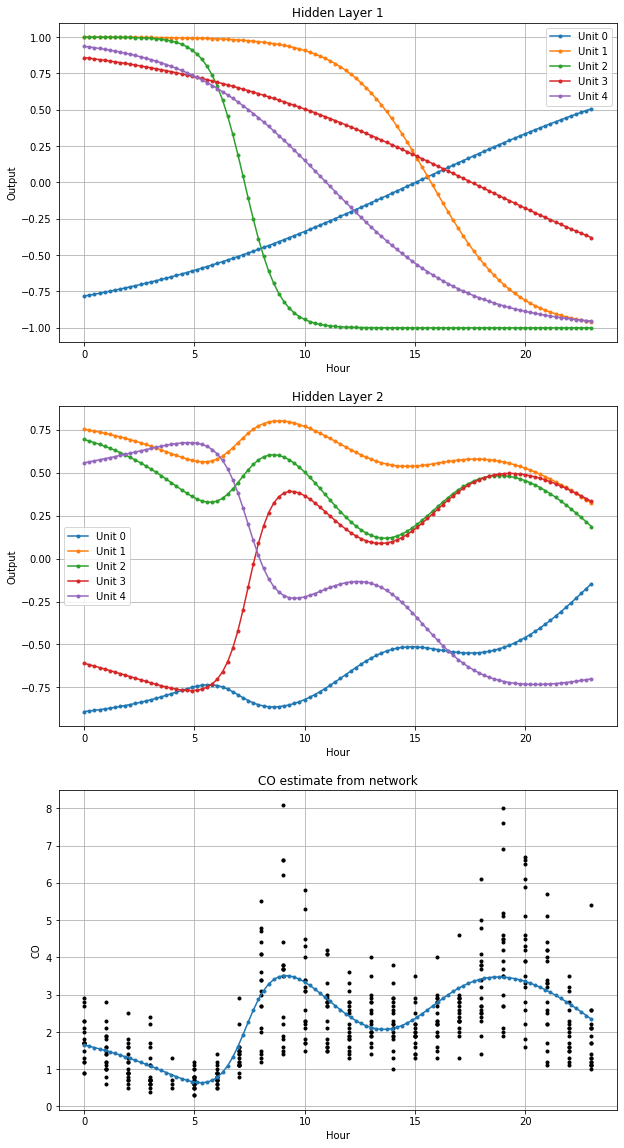

In [31]:
plt.figure(figsize=(10, 20))
plt.subplot(3, 1, 1)
plt.title('Hidden Layer 1')
plt.plot(x_test, Z1[:,0], '.-', label='Unit 0')
plt.plot(x_test, Z1[:,1], '.-', label='Unit 1')
plt.plot(x_test, Z1[:,2], '.-', label='Unit 2')
plt.plot(x_test, Z1[:,3], '.-', label='Unit 3')
plt.plot(x_test, Z1[:,4], '.-', label='Unit 4')
plt.legend()
plt.grid(True)
plt.xlabel('Hour')
plt.ylabel('Output');

plt.subplot(3, 1, 2)
plt.title('Hidden Layer 2')
plt.plot(x_test, Z2[:,0], '.-', label='Unit 0')
plt.plot(x_test, Z2[:,1], '.-', label='Unit 1')
plt.plot(x_test, Z2[:,2], '.-', label='Unit 2')
plt.plot(x_test, Z2[:,3], '.-', label='Unit 3')
plt.plot(x_test, Z2[:,4], '.-', label='Unit 4')
plt.legend()
plt.grid(True)
plt.xlabel('Hour')
plt.ylabel('Output');

plt.subplot(3, 1, 3)
plt.title('CO estimate from network')
plt.plot(X, T, 'k.')
plt.plot(x_test, Y, '.-')
plt.grid(True)
plt.xlabel('Hour')
plt.ylabel('CO');

### Describe results

The first two plots show the output of each unit vs the 100 points of input data.  The first layer produced much smother, piece-wise linear results, while the second layer looks to have much more sinusoidal shapes.  For both hidden layers, unit 0 starts off negative and increases over time and units 1, 2 and 4 start off positive and decrease over time.  The final plot shows the predicted output from the trained neural network.  The black dots represent the actual data, which was used to train the network, and the blue dotted line shows the prediction for all 100 values.  Overall, I think the predicted values match the actual values extremely well.